## Notebook Setup
***

In [268]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import plotly.graph_objects as go
import plotly.subplots as sp

## Data Import
***

In [269]:
sp_500_stocks=pd.read_csv("../data/sp500_stocks.csv")
sp500_Index = pd.read_csv("../data/sp500_index.csv")
marketInfo = pd.read_csv("../data/Stock Market Dataset.csv")

## EDA
***

In [270]:
type(sp_500_stocks)
sp_500_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796716 entries, 0 to 1796715
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date       object 
 1   Symbol     object 
 2   Adj Close  float64
 3   Close      float64
 4   High       float64
 5   Low        float64
 6   Open       float64
 7   Volume     float64
dtypes: float64(6), object(2)
memory usage: 109.7+ MB


In [271]:
sp_500_stocks.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,53.295383,83.019997,83.449997,82.669998,83.089996,3043700.0
1,2010-01-05,MMM,52.961575,82.500000,83.230003,81.699997,82.800003,2847000.0
2,2010-01-06,MMM,53.712673,83.669998,84.599998,83.510002,83.879997,5268500.0
3,2010-01-07,MMM,53.751171,83.730003,83.760002,82.120003,83.320000,4470100.0
4,2010-01-08,MMM,54.129940,84.320000,84.320000,83.300003,83.690002,3405800.0


In [272]:
sp_500_stocks["Date"] = pd.to_datetime(sp_500_stocks["Date"], infer_datetime_format=True)
sp_500_stocks.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796716 entries, 0 to 1796715
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Date       datetime64[ns]
 1   Symbol     object        
 2   Adj Close  float64       
 3   Close      float64       
 4   High       float64       
 5   Low        float64       
 6   Open       float64       
 7   Volume     float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 109.7+ MB


In [273]:
sp_500_stocks["Symbol"].value_counts()

MMM     3572
MSCI    3572
NOC     3572
NTRS    3572
NSC     3572
        ... 
ECL     3572
EBAY    3572
ETN     3572
EMN     3572
ZTS     3572
Name: Symbol, Length: 503, dtype: int64

In [274]:
sp_500_adj_close_sum = sp_500_stocks.groupby(sp_500_stocks["Date"])['Adj Close'].sum()

In [275]:
sp_500_close_sum =sp_500_stocks.groupby(sp_500_stocks.Date.dt.date)['Close'].sum()

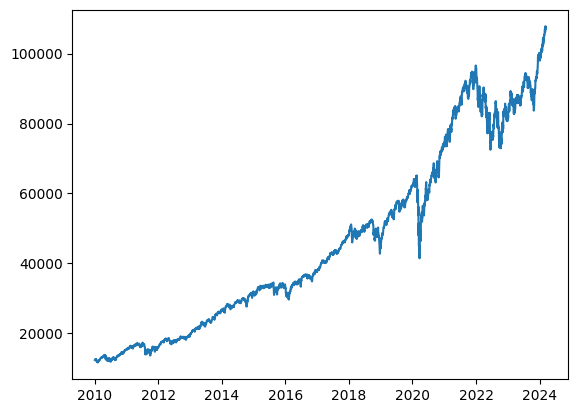

In [276]:
plt.plot(sp_500_adj_close_sum)

<class 'pandas.core.series.Series'>
Index: 3572 entries, 2010-01-04 to 2024-03-13
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
3572 non-null   float64
dtypes: float64(1)
memory usage: 55.8+ KB


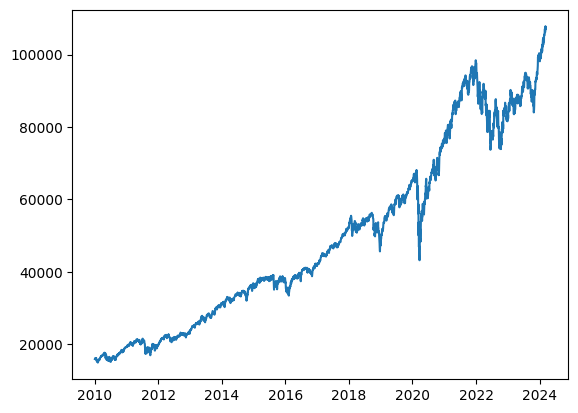

In [277]:
sp_500_close_sum.info()
plt.plot(sp_500_close_sum)

In [278]:
sp500_Index.head()
#sp500_Index.info()

,Date,S&P500
0,2014-03-14,1841.13
1,2014-03-17,1858.83
2,2014-03-18,1872.25
3,2014-03-19,1860.77
4,2014-03-20,1872.01


In [279]:
sp500_Index["Date"] = pd.to_datetime(sp500_Index["Date"])
sp500_Index=sp500_Index.rename({"Date": "date", "S&P500": "sp"}, axis=1)

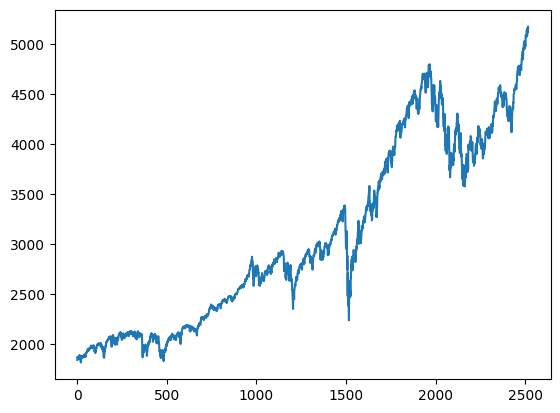

In [280]:
plt.plot(sp500_Index.index,sp500_Index["sp"])

## Decomposition
***

In [281]:
sp500_Index

,date,sp
0,2014-03-14,1841.13
1,2014-03-17,1858.83
2,2014-03-18,1872.25
3,2014-03-19,1860.77
4,2014-03-20,1872.01
...,...,...
2512,2024-03-07,5157.36
2513,2024-03-08,5123.69
2514,2024-03-11,5117.94
2515,2024-03-12,5175.27


In [282]:
#sp500_Index.loc[(sp500_Index['Date'] >= '2014-04-01') & (sp500_Index['Date'] < '2014-05-01')]

sp500_Index.set_index('date', inplace=True)
#sp500_Index = sp500_Index.resample(20).mean().ffill()
#sp500_Index.head()

In [283]:
seasonalTrendLoess_IDX = STL(sp500_Index['sp'], period=20)
result = seasonalTrendLoess_IDX.fit()
trend = result.trend
seasonal = result.seasonal
residual = result.resid

In [284]:
fig = go.Figure()

fig = sp.make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=['Original', 'Trend', 'Seasonal', 'Residual'], vertical_spacing=0.05)
fig.add_trace(go.Scatter(x=sp500_Index.index, y=sp500_Index['sp'], mode='lines', name='Original'), row=1, col=1)
fig.add_trace(go.Scatter(x=sp500_Index.index, y=trend, mode='lines', name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(x=sp500_Index.index, y=seasonal, mode='lines', name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=sp500_Index.index, y=residual, mode='lines', name='Residual'), row=4, col=1)

fig.update_layout(title_text='STL Decomposition of S&P500', showlegend=False, height=1300)

fig.show()

In [285]:
p, d, q = 1, 1, 1
arima_model = ARIMA(sp500_Index['sp'], order=(p, d, q))
arima_results = arima_model.fit()

trend = arima_results.fittedvalues
seasonal = arima_results.resid
residuals = arima_results.resid

fig = go.Figure()

fig = sp.make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=['Original', 'Trend', 'Seasonal', 'Residual'], vertical_spacing=0.05)
fig.add_trace(go.Scatter(x=sp500_Index.index, y=sp500_Index['sp'], mode='lines', name='Original'), row=1, col=1)
fig.add_trace(go.Scatter(x=sp500_Index.index, y=trend, mode='lines', name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(x=sp500_Index.index, y=seasonal, mode='lines', name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=sp500_Index.index, y=residual, mode='lines', name='Residual'), row=4, col=1)

fig.update_layout(title_text='STL Decomposition of S&P500', showlegend=False, height=1300)

fig.show()

C:\Users\qjhar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\qjhar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\qjhar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



## Stock Market Commodities 5-yr Visualizations
***

In [286]:
marketInfo.head()

,Unnamed: 0,Date,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,...,Berkshire_Price,Berkshire_Vol.,Netflix_Price,Netflix_Vol.,Amazon_Price,Amazon_Vol.,Meta_Price,Meta_Vol.,Gold_Price,Gold_Vol.
0,0,02-02-2024,2.079,NaN,72.28,NaN,3.8215,NaN,"43,194.70",42650.0,...,"5,89,498",10580.0,564.64,4030000.0,171.81,117220000.0,474.99,84710000.0,"2,053.70",NaN
1,1,01-02-2024,2.050,161340.0,73.82,577940.0,3.8535,NaN,"43,081.40",47690.0,...,"5,81,600",9780.0,567.51,3150000.0,159.28,66360000.0,394.78,25140000.0,"2,071.10",260920.0
2,2,31-01-2024,2.100,142860.0,75.85,344490.0,3.9060,NaN,"42,580.50",56480.0,...,"5,78,020",9720.0,564.11,4830000.0,155.20,49690000.0,390.14,20010000.0,"2,067.40",238370.0
3,3,30-01-2024,2.077,139750.0,77.82,347240.0,3.9110,NaN,"42,946.20",55130.0,...,"5,84,680",9750.0,562.85,6120000.0,159.00,42290000.0,400.06,18610000.0,"2,050.90",214590.0
4,4,29-01-2024,2.490,3590.0,76.78,331930.0,3.8790,NaN,"43,299.80",45230.0,...,"5,78,800",13850.0,575.79,6880000.0,161.26,42840000.0,401.02,17790000.0,"2,034.90",1780.0


In [287]:
#marketInfo["Date"]
ng_5yr = marketInfo[["Date","Natural_Gas_Price"]].copy()
ng_5yr=ng_5yr.rename({"Date": "date"}, axis=1)
#ng_5yr.set_index('date', inplace=True)
#ng_5yr=pd.to_datetime(ng_5yr["date"], infer_datetime_format=True)


ng_5yr.head()

,date,Natural_Gas_Price
0,02-02-2024,2.079
1,01-02-2024,2.050
2,31-01-2024,2.100
3,30-01-2024,2.077
4,29-01-2024,2.490


<AxesSubplot: xlabel='date'>

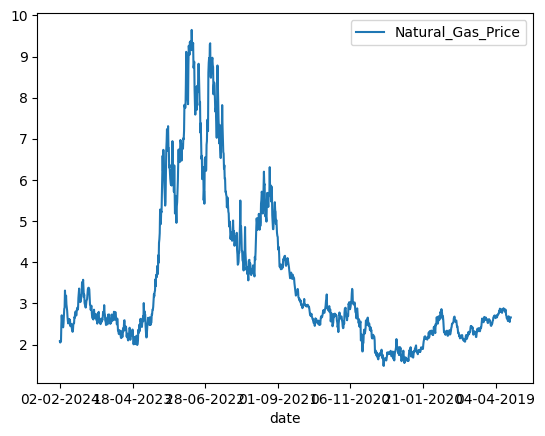

In [288]:
ng_5yr.plot(x='date', y='Natural_Gas_Price')

In [289]:
#marketInfo.head()
crude_5yr = marketInfo[['Date','Crude_oil_Price']].copy()
crude_5yr=crude_5yr.rename({"Date": "date"}, axis=1)
crude_5yr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             1243 non-null   object 
 1   Crude_oil_Price  1243 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.5+ KB


<AxesSubplot: xlabel='date'>

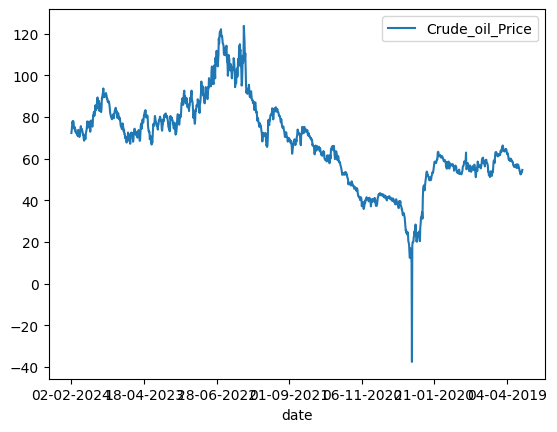

In [290]:
crude_5yr.plot(x='date', y='Crude_oil_Price')
#crude_5yr

In [291]:
copper_5yr = marketInfo[["Date","Copper_Price"]].copy()
copper_5yr=copper_5yr.rename({"Date": "date"}, axis=1)
copper_5yr.head()

,date,Copper_Price
0,02-02-2024,3.8215
1,01-02-2024,3.8535
2,31-01-2024,3.9060
3,30-01-2024,3.9110
4,29-01-2024,3.8790


<AxesSubplot: xlabel='date'>

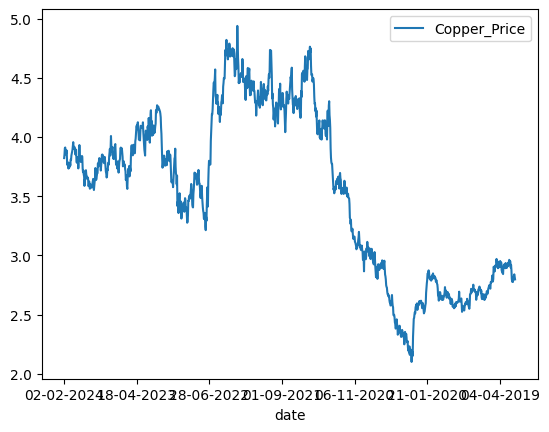

In [292]:
copper_5yr.plot(x='date', y='Copper_Price')

In [301]:
gold_5yr = marketInfo[["Date","Gold_Price"]].copy()
gold_5yr=gold_5yr.rename({"Date": "date"}, axis=1)
gold_5yr['Gold_Price'] = gold_5yr['Gold_Price'].str.replace(',', '').astype('float')
gold_5yr.head()

,date,Gold_Price
0,02-02-2024,2053.7
1,01-02-2024,2071.1
2,31-01-2024,2067.4
3,30-01-2024,2050.9
4,29-01-2024,2034.9


<AxesSubplot: xlabel='date'>

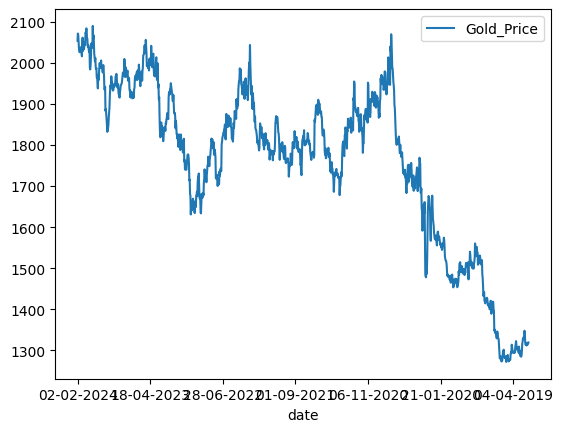

In [302]:
gold_5yr.plot(x='date', y='Gold_Price')

In [309]:
ComSum_5yr = marketInfo[["Date"]].copy()
ComSum_5yr['CommoditySum'] = marketInfo[['Natural_Gas_Price','Crude_oil_Price','Copper_Price']].sum(axis=1)
ComSum_5yr['CommoditySum'] = ComSum_5yr['CommoditySum'] + marketInfo['Gold_Price'].str.replace(',', '').astype('float')
ComSum_5yr=ComSum_5yr.rename({"Date": "date"}, axis=1)
ComSum_5yr.head()

,date,CommoditySum
0,02-02-2024,2131.8805
1,01-02-2024,2150.8235
2,31-01-2024,2149.2560
3,30-01-2024,2134.7080
4,29-01-2024,2118.0490


<AxesSubplot: xlabel='date'>

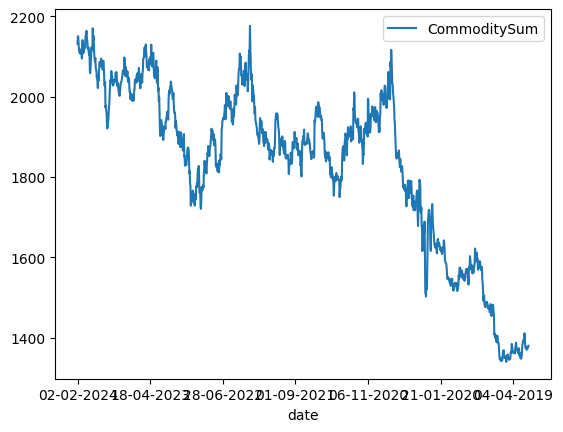

In [310]:
ComSum_5yr.plot(x='date', y='CommoditySum')

In [312]:
ComAvg_5yr = marketInfo[["Date"]].copy()
ComAvg_5yr['CommodityAvg'] = (marketInfo[['Natural_Gas_Price','Crude_oil_Price','Copper_Price']].sum(axis=1) + marketInfo['Gold_Price'].str.replace(',', '').astype('float') / 4)
#ComAvg_5yr['CommodityAvg'] = ComSum_5yr['CommodityAvg'] + marketInfo['Gold_Price'].str.replace(',', '').astype('float')
ComAvg_5yr=ComAvg_5yr.rename({"Date": "date"}, axis=1)
ComAvg_5yr.head()

,date,CommodityAvg
0,02-02-2024,591.6055
1,01-02-2024,597.4985
2,31-01-2024,598.7060
3,30-01-2024,596.5330
4,29-01-2024,591.8740


<AxesSubplot: xlabel='date'>

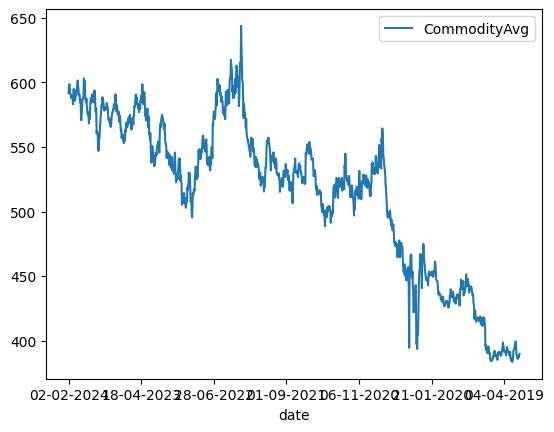

In [314]:
ComAvg_5yr.plot(x='date', y='CommodityAvg')

In [315]:
sp500_Index

,sp
date,
2014-03-14,1841.13
2014-03-17,1858.83
2014-03-18,1872.25
2014-03-19,1860.77
2014-03-20,1872.01
...,...
2024-03-07,5157.36
2024-03-08,5123.69
2024-03-11,5117.94


In [323]:
sp500_Index_Long = sp500_Index.copy()
sp500_Index_Long['year'] = pd.DatetimeIndex(sp500_Index_Long.index).year
sp500_Index_Long['month'] = pd.DatetimeIndex(sp500_Index_Long.index).month
sp500_Index_Long
#sp500_Index_wide= pd.pivot(sp500_Index_Long, index='month', columns='year', values='sp')
#sp500_Index_wide.reset_index(inplace=True)
#sp500_Index_wide.head()

,sp,year,month
date,,,
2014-03-14,1841.13,2014,3
2014-03-17,1858.83,2014,3
2014-03-18,1872.25,2014,3
2014-03-19,1860.77,2014,3
2014-03-20,1872.01,2014,3
...,...,...,...
2024-03-07,5157.36,2024,3
2024-03-08,5123.69,2024,3
2024-03-11,5117.94,2024,3
